In [21]:
import numpy as np
import pandas as pd
import json
import pandas_market_calendars as mcal
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
# from utils.finance_metrics import annualized_return

TRADING_DAYS = 252

In [22]:
pairs = {eval(k): v for k,v in dict(json.loads(open("data/info/pairs.json", "r").read())).items()}
pairs

{('ADX', 'TY'): 0.853938041834032,
 ('ED', 'SO'): 0.7630684994843583,
 ('AEG', 'ING'): 0.7714520036919487,
 ('GOLD', 'NEM'): 0.8219942702537909,
 ('AVB', 'EQR'): 0.8793959812778221,
 ('AMAT', 'KLAC'): 0.8120695844768887,
 ('APA', 'DVN'): 0.7797792484401138,
 ('ARW', 'AVT'): 0.7573572791543869,
 ('CMA', 'TFC'): 0.8089975734507149,
 ('GFI', 'HMY'): 0.7721582544936532,
 ('BAC', 'WFC'): 0.8033690173669585,
 ('BBVA', 'SAN'): 0.8696850470469416,
 ('HIW', 'KRC'): 0.8127703586697915,
 ('BEN', 'TROW'): 0.7533682263460231,
 ('BK', 'NTRS'): 0.7853258900728711,
 ('HAL', 'SLB'): 0.7707796197283248,
 ('BMO', 'RY'): 0.8112242300303579,
 ('E', 'TOT'): 0.8145755214453303,
 ('BXP', 'VNO'): 0.8658210823728937,
 ('CCL', 'RCL'): 0.7796060510803956,
 ('CM', 'TD'): 0.7955914439701682,
 ('CVX', 'XOM'): 0.8257217118360992,
 ('CPT', 'UDR'): 0.8316230952071983,
 ('CSX', 'NSC'): 0.7742776958878398,
 ('CUZ', 'WRE'): 0.7571898754103825,
 ('DHI', 'LEN'): 0.8014581824672958,
 ('DRE', 'PLD'): 0.8245693410742715,
 ('EL

In [23]:
pair = ('ADX', 'TY')
# initialize dataframe with trading day indices
dates = mcal.get_calendar('NYSE').schedule(start_date="1999-01-01", end_date="2021-03-01").index
pair_df = pd.DataFrame(index=dates)  # trading dates

df_A = pd.read_pickle("data/raw/" + pair[0] + ".zip")  # needs pickle5 compression (python 3.8)
df_B = pd.read_pickle("data/raw/" + pair[1] + ".zip")  # needs pickle5 compression (python 3.8)

# add the return columns
pair_df["Log Ret. A"] = df_A["Log Return"]
pair_df["Log Ret. B"] = df_B["Log Return"]

# establish the rolling windows for both tickers in the pair
rolling_1w_A = df_A["Log Return"].rolling(10)
rolling_1m_A = df_A["Log Return"].rolling(21)
rolling_3m_A = df_A["Log Return"].rolling(63)
rolling_6m_A = df_A["Log Return"].rolling(126)
rolling_1y_A = df_A["Log Return"].rolling(252)
rolling_1w_B = df_B["Log Return"].rolling(10)
rolling_1m_B = df_B["Log Return"].rolling(21)
rolling_3m_B = df_B["Log Return"].rolling(63)
rolling_6m_B = df_B["Log Return"].rolling(126)
rolling_1y_B = df_B["Log Return"].rolling(252)

# add the rolling volatility ratios 
pair_df["1W Vol."] = rolling_1w_A.std(ddof=0) / rolling_1w_B.std(ddof=0)
pair_df["1M Vol."] = rolling_1m_A.std(ddof=0) / rolling_1m_B.std(ddof=0)
pair_df["3M Vol."] = rolling_3m_A.std(ddof=0) / rolling_3m_B.std(ddof=0)
pair_df["6M Vol."] = rolling_6m_A.std(ddof=0) / rolling_6m_B.std(ddof=0)
pair_df["1Y Vol."] = rolling_1y_A.std(ddof=0) / rolling_1y_B.std(ddof=0)

# add the rolling mean return differences
pair_df["1W Ret."] = rolling_1w_A.mean() - rolling_1w_B.mean()
pair_df["1M Ret."] = rolling_1m_A.mean() - rolling_1m_B.mean()
pair_df["3M Ret."] = rolling_3m_A.mean() - rolling_3m_B.mean()
pair_df["6M Ret."] = rolling_6m_A.mean() - rolling_6m_B.mean()
pair_df["1Y Ret."] = rolling_1y_A.mean() - rolling_1y_B.mean()

pair_df.fillna(0, inplace=True)

# this is the target column: when diff > 1, return is greater for pair[0], else return is greater for pair[1]
pair_df["Return Diff (t+1)"] = df_A["Simple Return"] - df_B["Simple Return"]
pair_df["Return Diff (t+1)"].shift(-1)  # shift so the return ratio at day t+1 moves to day t

pair_df.loc["2000-01-01":, :]

,Log Ret. A,Log Ret. B,1W Vol.,1M Vol.,3M Vol.,6M Vol.,1Y Vol.,1W Ret.,1M Ret.,3M Ret.,6M Ret.,1Y Ret.,Return Diff (t+1)
2000-01-03,-0.003732,-0.022677,0.858397,0.773041,1.050669,0.972499,1.144413,0.011071,0.006367,0.002754,0.001558,0.000829,0.019197
2000-01-04,-0.013170,-0.011535,1.088119,0.783751,1.074592,0.977204,1.147183,0.008792,0.005883,0.003034,0.001529,0.000829,-0.001656
2000-01-05,-0.007605,-0.006985,1.023830,0.831225,1.083355,0.980879,1.144702,0.006522,0.005936,0.003020,0.001622,0.000804,-0.000625
2000-01-06,0.000000,0.018519,0.795298,0.738002,1.052704,0.963774,1.131265,0.004389,0.004765,0.002658,0.001457,0.000749,-0.018349
2000-01-07,0.003810,0.006857,0.743933,0.747537,1.049318,0.961216,1.129837,0.002021,0.003893,0.002574,0.001450,0.000711,-0.003031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-23,-0.001123,-0.001290,1.225154,1.238262,1.471214,1.214455,0.974814,-0.000889,-0.000342,-0.001090,-0.000594,-0.000112,0.000167
2021-02-24,0.012284,0.008672,1.361912,1.252530,1.120482,1.219441,0.972466,-0.001254,-0.000208,-0.000289,-0.000528,-0.000057,0.003574
2021-02-25,-0.020747,-0.012551,1.451676,1.299508,1.159543,1.225429,0.973629,-0.001283,-0.000587,-0.000302,-0.000608,-0.000090,-0.008334
2021-02-26,-0.003405,-0.000648,1.437548,1.324815,1.161508,1.223314,0.971099,-0.001911,-0.000419,-0.000372,-0.000684,-0.000076,-0.002763


In [24]:
model = ElasticNet()
model.fit(np.array(pair_df.loc["2000-01-01":"2014-12-31", :].drop(columns="Return Diff (t+1)")),
          np.array(pair_df.loc["2000-01-01":"2014-12-31", "Return Diff (t+1)"]))
pred_diff = model.predict(np.array(pair_df.loc["2015-01-01":, :].drop(columns="Return Diff (t+1)")))
len(pred_diff)

1550

In [25]:
len(np.array(pair_df.loc["2015-01-01":, "Return Diff (t+1)"]))

1550

In [26]:
print(np.std(np.array(pair_df.loc["2000-01-01":"2014-12-31", "Return Diff (t+1)"])))
print(np.mean(np.array(pair_df.loc["2000-01-01":"2014-12-31", "Return Diff (t+1)"])))
print(np.min(np.array(pair_df.loc["2000-01-01":"2014-12-31", "Return Diff (t+1)"])))
print(np.max(np.array(pair_df.loc["2000-01-01":"2014-12-31", "Return Diff (t+1)"])))
mean_squared_error(np.array(pair_df.loc["2015-01-01":, "Return Diff (t+1)"]), pred_diff)

0.006816927387703143
3.948789574456831e-05
-0.04171816924864856
0.08396763204999211


2.5710565029871527e-05

In [27]:
df_copy = pd.DataFrame(index=dates)
df_copy["A"] = df_A.loc[:,["Simple Return"]]
df_copy["B"] = df_B.loc[:,["Simple Return"]]


df_copy.fillna(0, inplace=True)
df_copy.iloc[0, :] += 1
df_copy

,A,B
1999-01-04,1.000000,1.000000
1999-01-05,0.009302,0.010870
1999-01-06,0.020501,0.014989
1999-01-07,-0.006881,-0.002146
1999-01-08,0.004566,-0.002151
...,...,...
2021-02-23,-0.001124,-0.001290
2021-02-24,0.012209,0.008635
2021-02-25,-0.020963,-0.012630
2021-02-26,-0.003411,-0.000648


<AxesSubplot:xlabel='Date'>

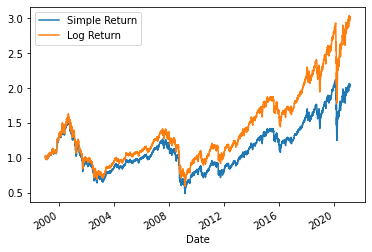

In [28]:
def annualized_return(returns_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate an return the annualized return for all columns in the returns DataFrame

    :param returns_df: the DataFrame of returns
    :return: a series of annualized returns for each column
    """
    cumprod_df = returns_df.copy(deep=True)
    cumprod_df.fillna(0, inplace=True)
    cumprod_df += 1
    return cumprod_df.cumprod(axis=0)

annualized_return(df_A.loc[:,["Simple Return", "Log Return"]]).plot()


